In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests 
from imp import reload 
import Util; reload(Util)
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import warnings
import Cdf
import seaborn as sns
import Pmf
warnings.filterwarnings('ignore')
from scipy import stats

# %matplotlib inline
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
data = pd.read_csv('../dataset/curr_webperf.csv', sep = ',', encoding = "ISO-8859-1")

In [3]:
# data prepareation 
data['dtime'] = data['dtime'].apply(Util.round_time_to_day)
data = data[data['dtime'] >= '2014-01-01']
data = data[data['rendering_time_100'] > 100]
data = data[data['rendering_time_100'] < 20100]
data = data[data['page_load_time_100'] > 100]
data = data[data['page_load_time_100'] < 20100]

In [4]:
len(set(data['unit_id']))

68

In [5]:
data.head()

,unit_id,dtime,target,cdn,http_elements,https_elements,http_redirects,dns_ok_n,dns_error_n,avg_dns_ok_time,...,rendering_time_40,rendering_time_50,rendering_time_60,rendering_time_70,rendering_time_80,rendering_time_90,rendering_time_100,successes,failures,location_id
0,195656,2015-12-12,http://www.bbc.com/,TOTAL,62,1,1,12,0,59.739254,...,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1,0,597540
1,195656,2015-12-12,http://www.ebay.com/,TOTAL,177,0,6,16,0,86.201569,...,600.0,600.0,600.0,600.0,600.0,600.0,600.0,1,0,597540
2,195656,2015-12-12,http://www.reddit.com/,TOTAL,38,0,2,7,0,51.046146,...,700.0,700.0,700.0,700.0,700.0,700.0,700.0,1,0,597540
4,195656,2015-12-12,http://www.bbc.com/,TOTAL,62,1,1,12,0,60.760162,...,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,1400.0,1,0,597540
5,195656,2015-12-12,http://www.reddit.com/,TOTAL,33,0,2,7,0,52.803001,...,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1,0,597540


In [6]:
targets = set(data['target'])

In [7]:
print('Website & Med & Mean')
for t in targets:
    w = data[data['target'] == t]
    print("%s & %.2f & %.2f " %(Util.get_base_url(t),
                               np.median(w['rendering_time_100'])/1000 ,np.mean(w['rendering_time_100'])/1000))

Website & Med & Mean
www.sina.com.cn & 2.00 & 3.27 
www.ebay.com & 1.30 & 2.59 
www.reddit.com & 0.80 & 1.34 
www.bbc.com & 1.20 & 1.60 


In [8]:
for t in targets:
    w = data[data['target'] == t]
    print("%s: # objects =  %d, Size = %.2f" %(Util.get_base_url(t), np.median(w['http_elements']) + np.median(w['https_elements']) ,
                                               np.median(w['avg_http_ok_download_size']) + np.median(w['avg_https_ok_download_size'])))

www.sina.com.cn: # objects =  125, Size = 16631.23
www.ebay.com: # objects =  176, Size = 17967.33
www.reddit.com: # objects =  36, Size = 29530.36
www.bbc.com: # objects =  62, Size = 23568.41


In [9]:
websites = Util.tables_site(data)
download_time = data['page_load_time_100'].div(1000)
rendering_time = data['rendering_time_100'].div(1000)
avg_ttfb = data['med_body_latency'].div(1000)

In [10]:
cdwnt = Cdf.MakeCdfFromList(download_time)
crndt = Cdf.MakeCdfFromList(rendering_time)
ctffb = Cdf.MakeCdfFromList(avg_ttfb)

In [11]:
# pearson Correlation 
dwn_rnd_data = data[['page_load_time_100', 'rendering_time_100', 'med_body_latency']]
dwn_rnd_data['dwn_rend_diff'] = dwn_rnd_data['page_load_time_100'] - dwn_rnd_data['rendering_time_100']
cdiff = Cdf.MakeCdfFromList(dwn_rnd_data['dwn_rend_diff'].div(1000))
pearson_corr = dwn_rnd_data.corr(method='pearson')
print("PLT vs REND: %.3f" %pearson_corr['page_load_time_100']['rendering_time_100'])
print("PLT vs TTFB: %.3f" %pearson_corr['page_load_time_100']['med_body_latency'])
print("REND vs TTFB: %.3f" %pearson_corr['med_body_latency']['rendering_time_100'])

PLT vs REND: 0.446
PLT vs TTFB: 0.554
REND vs TTFB: 0.279


In [12]:
dwn_rnd_data[['med_body_latency', 'page_load_time_100', 'rendering_time_100', \
              'dwn_rend_diff']].quantile([.1,0.2,0.5,.75,.9])

,med_body_latency,page_load_time_100,rendering_time_100,dwn_rend_diff
0.10,58.758600,1040.418603,400.0,-585.231201
0.20,74.034198,1367.144556,600.0,-4.224780
0.50,135.186996,2567.690918,1200.0,1106.262939
0.75,181.521500,5223.300781,2200.0,2983.924072
0.90,288.426397,10180.327539,4800.0,6801.123926


In [13]:
dwn_rnd_data[['med_body_latency', 'page_load_time_100', 'rendering_time_100', \
              'dwn_rend_diff']].describe()

,med_body_latency,page_load_time_100,rendering_time_100,dwn_rend_diff
count,100273.000000,100273.000000,100273.000000,100273.000000
mean,161.394364,4197.003621,2020.403299,2176.600322
std,133.538516,4033.553120,2563.248487,3691.237232
min,0.000000,282.032990,200.000000,-17565.808960
25%,79.890999,1513.041016,700.000000,185.501953
50%,135.186996,2567.690918,1200.000000,1106.262939
75%,181.521500,5223.300781,2200.000000,2983.924072
max,1828.510986,20098.292969,20000.000000,19898.292969


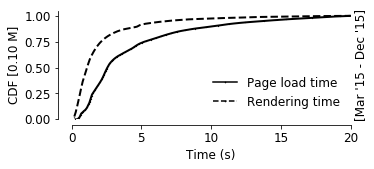

In [14]:
# CDF of two values 
fig = plt.figure(figsize=(5, 2))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.25)

plt.plot(cdwnt.xs, cdwnt.ps, marker='s', linestyle = '-', linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = 'black', markevery=1500)
plt.plot(crndt.xs, crndt.ps, marker='o',linestyle = '--', linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = 'black', markevery=1501)

ylab = "CDF [%.2f M]" %(len(cdwnt.xs) / 1000000)

ax = fig.axes[0]
# ax.grid(True)
ax.set_yticks(yticks)
ax.set_xlim([0,20])
ax.set_ylim([0,1.05])
# ax.set_xscale('symlog', basex = 2)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel(ylab, fontsize=12)

leg = plt.legend(["Page load time",  "Rendering time"],
           fontsize=12, markerscale=2., loc='best', frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    legobj.set_markersize(0.5)
leg.get_frame().set_facecolor('none')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[Mar \'15 - Dec \'15]')
plt.setp(ax3.get_yticklabels(), visible=False)

# plt.title('Download and Rendering time', fontsize=12, y=1.0)
plt.savefig('../gfx/wepr_download_rendering_cdf.pdf', format='pdf', bbox_inches='tight')

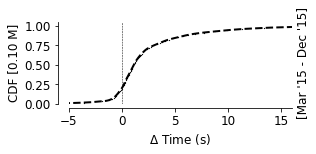

In [15]:
# CDF of the differnnce between download and rendering time
cdiff = Cdf.MakeCdfFromList(dwn_rnd_data['dwn_rend_diff'].div(1000))

fig = plt.figure(figsize=(4, 1.5))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.25)

plt.plot(cdiff.xs, cdiff.ps, marker='s', linestyle = '--', linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = 'black', markevery=1500)
ylab = "CDF [%.2f M]" %(len(cdiff.xs) / 1000000)

ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_xlim([-5,16])
ax.set_ylim([0,1.05])
ax.set_xscale('linear')
ax.set_xlabel(r'$\Delta $ Time (s)', fontsize=12)
ax.set_ylabel(ylab, fontsize=12)

# leg = plt.legend(["Difference"],
#            fontsize=12, markerscale=2., loc='best', frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    legobj.set_markersize(0.5)
leg.get_frame().set_facecolor('none')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[Mar \'15 - Dec \'15]')
plt.setp(ax3.get_yticklabels(), visible=False)
ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)

#plt.title('Difference Download and Rendering time', fontsize=12, y=1.0)
plt.savefig('../gfx/wepr_download_rendering_diff_cdf.pdf', format='pdf', bbox_inches='tight')

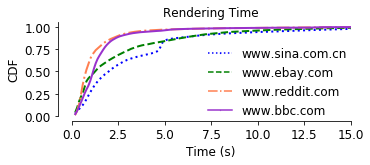

In [16]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.25)

ax1 = fig.add_subplot(411)

colors = ['blue', 'Green', 'Coral', 'darkorchid']
markers = ['s', 'o', '3', '8']
linestyle = [':', '--', '-.', '-']
i = 0
legends = []
for w in set(data['target']):
    website_rend = websites[w]['rendering_time_100'].div(1000)
    c_web_rend = Cdf.MakeCdfFromList(website_rend)
    ax1.plot(c_web_rend.xs, c_web_rend.ps, marker= markers[i], linestyle = linestyle[i],
             linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = colors[i], markevery=151)
    i+=1
    legends.append(Util.get_base_url(w))
ylab = "CDF"
ax1.grid(False)
ax1.set_yticks(yticks)
ax1.set_xlim([0,15])
ax1.set_ylim([0,1.05])
ax1.set_xscale('linear')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel(ylab, fontsize=12, )
ax1.set_title("Rendering Time", fontsize = 12)
#ax1.yaxis.set_label_coords(-0.25, -0.3)
    
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

leg = ax1.legend(legends, 
           fontsize=12, markerscale=1., loc='best', bbox_to_anchor=(0.45, 0.85), frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)

fig.subplots_adjust(hspace = 0.6)
plt.savefig('../gfx/wepr_website_rend_cdf.pdf', format='pdf', bbox_inches='tight')

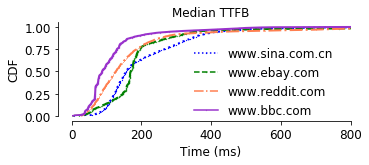

In [17]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.25)

ax1 = fig.add_subplot(411)

colors = ['blue', 'Green', 'Coral', 'darkorchid']
markers = ['s', 'o', '3', '8']
linestyle = [':', '--', '-.', '-']
i = 0
legends = []
for w in set(data['target']):
    website_rend = websites[w]['med_body_latency']
    c_web_rend = Cdf.MakeCdfFromList(website_rend)
    ax1.plot(c_web_rend.xs, c_web_rend.ps, marker= markers[i], linestyle = linestyle[i],
             linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = colors[i], markevery=151)
    i+=1
    legends.append(Util.get_base_url(w))
ylab = "CDF"
ax1.grid(False)
ax1.set_yticks(yticks)
ax1.set_xlim([0,800])
ax1.set_ylim([0,1.05])
ax1.set_xscale('linear')
ax1.set_xlabel('Time (ms)', fontsize=12)
ax1.set_ylabel(ylab, fontsize=12, )
ax1.set_title("Median TTFB", fontsize = 12)
#ax1.yaxis.set_label_coords(-0.25, -0.3)
    
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

leg = ax1.legend(legends, 
           fontsize=12, markerscale=1., loc='best', bbox_to_anchor=(0.4, 0.85), frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)

fig.subplots_adjust(hspace = 0.6)
plt.savefig('../gfx/wepr_website_ttfb_cdf.pdf', format='pdf', bbox_inches='tight')

In [18]:
df_validation_new = pd.read_csv('../dataset/wepr_validation_result_18.csv', sep = ',', encoding = "ISO-8859-1")
df_validation_new = df_validation_new[df_validation_new['url'] != 'http://comnet.aalto.fi/en/']
df_validation_new = df_validation_new[df_validation_new['url'] != 'http://www.httpvshttps.com']
df_validation_new = df_validation_new[df_validation_new['url'] != 'http://www.speedcheker.xyz/']
df_validation_new = df_validation_new[df_validation_new['url'] != 'http://www.challengeturku.com']
df_validation_new.drop(df_validation_new.columns[[-1,]], axis=1, inplace=True)
df_validation_new = df_validation_new[df_validation_new['webperf'] > 100]
df_validation_new = df_validation_new[df_validation_new['firefox'] > 100]
# df_validation_new = df_validation_new[df_validation_new['chrome'] > 100]

df_validation_new['webperf'] = df_validation_new['webperf'].div(1000)
df_validation_new['firefox'] = df_validation_new['firefox'].div(1000)
# df_validation_new['chrome'] = df_validation_new['chrome'].div(1000)
df_validation_new['delta'] = df_validation_new['webperf'] - df_validation_new['firefox']
df_validation_new.tail()

,url,webperf,firefox,delta
1652,http://tube251.com,3.2,2.9,0.3
1653,http://www.cm.in.tum.de/en/home/,1.1,1.5,-0.4
1654,http://www.speedchecker.xyz/,0.8,0.6,0.2
1655,http://www.helmet.fi/en-US,2.4,1.3,1.1
1656,http://www.ts.fi,1.6,1.2,0.4


In [19]:
(set(df_validation_new['url']))

{'http://seppo.io/en/',
 'http://tube251.com',
 'http://www.cm.in.tum.de/en/home/',
 'http://www.helmet.fi/en-US',
 'http://www.jyvaskyla.fi/international/',
 'http://www.maistraatti.fi/en/',
 'http://www.speedchecker.xyz/',
 'http://www.studyinfinland.fi',
 'http://www.ts.fi',
 'http://www.ymparisto.fi/en-US/'}

In [20]:
df_validation_new.describe()

,webperf,firefox,delta
count,1539.000000,1539.000000,1539.000000
mean,1.988694,1.866017,0.122677
std,1.730523,1.303574,1.702656
min,0.300000,0.200000,-9.400000
25%,1.000000,1.000000,-0.500000
50%,1.400000,1.400000,0.000000
75%,2.300000,2.700000,0.400000
max,13.100000,12.900000,12.100000


In [21]:
df_validation_new.quantile([.1, .25, .5, .6, .75, .95])

,webperf,firefox,delta
0.10,0.8,0.7,-1.30
0.25,1.0,1.0,-0.50
0.50,1.4,1.4,0.00
0.60,1.6,1.8,0.20
0.75,2.3,2.7,0.40
0.95,5.4,3.8,2.71


In [22]:
for q in [.1, .25, .5, .75, .85]:
    print("{} & {} & {}".format(q*100, list(df_validation_new.quantile([q])['webperf'])[0], \
                               list(df_validation_new.quantile([q])['firefox'])[0]))

10.0 & 0.8 & 0.7
25.0 & 1.0 & 1.0
50.0 & 1.4 & 1.4
75.0 & 2.3 & 2.7
85.0 & 3.1 & 3.0


In [23]:
cwebperf = Cdf.MakeCdfFromList(df_validation_new['webperf'])
cfirefox = Cdf.MakeCdfFromList(df_validation_new['firefox'])
# cchrome = Cdf.MakeCdfFromList(df_validation_new['chrome'])


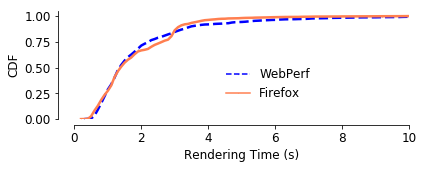

In [24]:
fig = plt.figure(figsize=(6, 2))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.25)

plt.plot(cwebperf.xs, cwebperf.ps, marker='o', linestyle = '--', linewidth=2.5, markersize=0.1,\
         fillstyle='none', color = 'blue', rasterized=True, markevery=15)
plt.plot(cfirefox.xs, cfirefox.ps, marker='+', linestyle = '-', linewidth=2.5, markersize=0.1,\
         fillstyle='none', color = 'coral', rasterized=True, markevery=15)
# plt.plot(cchrome.xs, cchrome.ps, marker='+', linestyle = '-', linewidth=2.5, markersize=0.1,\
#          fillstyle='none', color = 'green', rasterized=True, markevery=15)

ylab = "CDF"

ax = fig.axes[0]
# ax.grid(True)
ax.set_yticks(yticks)
ax.set_xlim([0,10])
ax.set_ylim([0,1.05])
# ax.set_xscale('symlog', basex =2)
ax.set_xlabel('Rendering Time (s)', fontsize=12)
ax.set_ylabel(ylab, fontsize=12)

#['Downloaded by Google Chrome', 'Downloaded by WebPerf']
leg = plt.legend(['WebPerf', 'Firefox', 'Google Chrome'],
           fontsize=12, markerscale=2., bbox_to_anchor=(0.42, 0.57),frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
leg.get_frame().set_facecolor('none')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))
# formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
# ax.xaxis.set_major_formatter(formatter)
ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
plt.setp(ax3.get_yticklabels(), visible=False)

#plt.title('Download and Rendering time', fontsize=12, y=1.0)
plt.savefig('../gfx/wepr_validation_cdf.pdf', format='pdf', bbox_inches='tight')

In [25]:
# pearson Correlation 
chrome_webperf = df_validation_new[['webperf', 'firefox']]
pearson_corr = chrome_webperf.corr(method='pearson')
# pearson_corr
round(pearson_corr['webperf']['firefox'], 2)

0.4

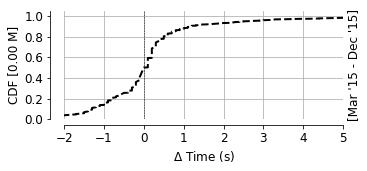

In [26]:
# CDF of the differnnce between download and rendering time
cdiff = Cdf.MakeCdfFromList(df_validation_new['delta'])

fig = plt.figure(figsize=(5, 2))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.2)

plt.plot(cdiff.xs, cdiff.ps, marker='s', linestyle = '--', linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = 'black', markevery=1500)
ylab = "CDF [%.2f M]" %(len(cdiff.xs) / 1000000)

ax = fig.axes[0]
ax.grid(True)
ax.set_yticks(yticks)
ax.set_xlim([-2,5])
ax.set_ylim([0,1.05])
ax.set_xscale('linear')
ax.set_xlabel(r'$\Delta $ Time (s)', fontsize=12)
ax.set_ylabel(ylab, fontsize=12)

# leg = plt.legend(["Difference"],
#            fontsize=12, markerscale=2., loc='best', frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    legobj.set_markersize(0.5)
leg.get_frame().set_facecolor('none')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[Mar \'15 - Dec \'15]')
plt.setp(ax3.get_yticklabels(), visible=False)
ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)

#plt.title('Difference Download and Rendering time', fontsize=12, y=1.0)
# plt.savefig('../gfx/wepr_download_rendering_diff_cdf.pdf', format='pdf', bbox_inches='tight')

## WePR benchmarking 

In [27]:
df_bench =  pd.read_csv('../dataset/wepr_bench.csv', sep = ',', encoding = "ISO-8859-1")
df_bench = df_bench[df_bench['cpu'] > 10]

In [28]:
cpu_time = df_bench['cpu']
memory =  df_bench['memory'].div(1000)

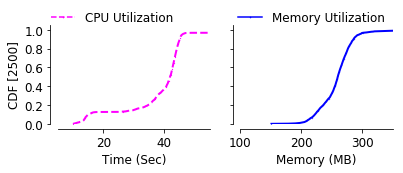

In [29]:
cCpu = Cdf.MakeCdfFromList(cpu_time)
cMemory = Cdf.MakeCdfFromList(memory)
fig = plt.figure(figsize=(6, 4))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.2)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(cCpu.xs, cCpu.ps, marker='s', linestyle = '--',
             linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = 'magenta', markevery=151)
ax2.plot(cMemory.xs, cMemory.ps, marker='o', linestyle = '-',
             linewidth=2.0, markersize=0.3, 
         fillstyle='none', color = 'blue', markevery=151)

ylab = "CDF [2500]"
ax1.grid(False)
ax1.set_yticks(yticks)
ax1.set_xlim([5,55])
ax1.set_ylim([0,1.05])
ax1.set_xscale('linear')
ax1.set_xlabel('Time (Sec)', fontsize=12)
ax1.set_ylabel(ylab, fontsize=12, )
    
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

ax1_3 = ax1.twinx()
ax1_3.spines['right'].set_color('none')
ax1_3.spines['top'].set_color('none')
ax1_3.spines['left'].set_color('none')
ax1_3.spines['bottom'].set_color('none')
ax1_3.yaxis.set_ticks_position('none')
# ax1_3.set_ylabel('[ 2500 ]')
plt.setp(ax1_3.get_yticklabels(), visible=False)

ax2.grid(False)
ax2.set_yticks(yticks)
ax2.set_xlim([100,350])
ax2.set_ylim([0,1.05])
ax2.set_xscale('linear')
ax2.set_xlabel('Memory (MB)', fontsize=12)
ax2.axes.yaxis.set_ticklabels([])

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.05))
ax2.spines['left'].set_position(('axes', -0.05))

ax2_3 = ax2.twinx()
ax2_3.spines['right'].set_color('none')
ax2_3.spines['top'].set_color('none')
ax2_3.spines['left'].set_color('none')
ax2_3.spines['bottom'].set_color('none')
ax2_3.yaxis.set_ticks_position('none')
# ax2_3.set_ylabel('[ 2500 ]')
plt.setp(ax2_3.get_yticklabels(), visible=False)

leg = ax1.legend(['CPU Utilization'],
           fontsize=12, markerscale=2., bbox_to_anchor=(0.83, 1.25),frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
leg.get_frame().set_facecolor('none')

leg = ax2.legend(['Memory Utilization'],
           fontsize=12, markerscale=2., bbox_to_anchor=(1.02, 1.25),frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
leg.get_frame().set_facecolor('none')

fig.subplots_adjust(hspace = 0.2)
plt.savefig('../gfx/wepr_bench_cdf.pdf', format='pdf', bbox_inches='tight')